In [11]:


# ========================
# 📦 Import Libraries
# ========================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from statistics import mode
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from imblearn.over_sampling import RandomOverSampler
import warnings



In [12]:
%pip install kagglehub
import kagglehub

# Download latest version
path = kagglehub.dataset_download("itachi9604/disease-symptom-description-dataset")

print("Path to dataset files:", path)
data1= pd.read_csv('dataset.csv')
data2=pd.read_csv('symptom_Description.csv')
data3=pd.read_csv('symptom_precaution.csv')
data4=pd.read_csv('Symptom-severity.csv')

data1.describe()


[notice] A new release of pip is available: 24.3.1 -> 25.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.
Path to dataset files: C:\Users\sunil\.cache\kagglehub\datasets\itachi9604\disease-symptom-description-dataset\versions\2


,Disease,Symptom_1,Symptom_2,Symptom_3,Symptom_4,Symptom_5,Symptom_6,Symptom_7,Symptom_8,Symptom_9,Symptom_10,Symptom_11,Symptom_12,Symptom_13,Symptom_14,Symptom_15,Symptom_16,Symptom_17
count,4920,4920,4920,4920,4572,3714,2934,2268,1944,1692,1512,1194,744,504,306,240,192,72
unique,41,34,48,54,50,38,32,26,21,22,21,18,11,8,4,3,3,1
top,Fungal infection,vomiting,vomiting,fatigue,high_fever,headache,nausea,abdominal_pain,abdominal_pain,yellowing_of_eyes,yellowing_of_eyes,irritability,malaise,muscle_pain,chest_pain,chest_pain,blood_in_sputum,muscle_pain
freq,120,822,870,726,378,348,390,264,276,228,198,120,126,72,96,144,72,72


In [13]:
data1.head()

,Disease,Symptom_1,Symptom_2,Symptom_3,Symptom_4,Symptom_5,Symptom_6,Symptom_7,Symptom_8,Symptom_9,Symptom_10,Symptom_11,Symptom_12,Symptom_13,Symptom_14,Symptom_15,Symptom_16,Symptom_17
0,Fungal infection,itching,skin_rash,nodal_skin_eruptions,dischromic _patches,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Fungal infection,skin_rash,nodal_skin_eruptions,dischromic _patches,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Fungal infection,itching,nodal_skin_eruptions,dischromic _patches,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Fungal infection,itching,skin_rash,dischromic _patches,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Fungal infection,itching,skin_rash,nodal_skin_eruptions,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [14]:
data2.head()

,Disease,Description
0,Drug Reaction,An adverse drug reaction (ADR) is an injury ca...
1,Malaria,An infectious disease caused by protozoan para...
2,Allergy,An allergy is an immune system response to a f...
3,Hypothyroidism,"Hypothyroidism, also called underactive thyroi..."
4,Psoriasis,Psoriasis is a common skin disorder that forms...


In [15]:
data4.head()

,Symptom,weight
0,itching,1
1,skin_rash,3
2,nodal_skin_eruptions,4
3,continuous_sneezing,4
4,shivering,5


In [17]:
# ========================
# 📂 Load Datasets
# ========================
# Make sure to update paths accordingly
df = pd.read_csv("dataset.csv").fillna("")
severity_df = pd.read_csv("Symptom-severity.csv")
precaution_df = pd.read_csv("symptom_precaution.csv").fillna("")



In [18]:

# Cleaning columns
severity_df.columns = severity_df.columns.str.strip().str.replace('\ufeff', '')
precaution_df.columns = precaution_df.columns.str.strip().str.replace('\ufeff', '')


In [19]:
# Dictionaries
symptom_severity = dict(zip(severity_df['Symptom'].str.lower().str.strip(), severity_df['weight']))
precaution_dict = {row["Disease"]: [row["Precaution_1"], row["Precaution_2"], row["Precaution_3"], row["Precaution_4"]] for _, row in precaution_df.iterrows()}



In [20]:
# ========================
# 🧹 Prepare Data
# ========================
all_symptoms = sorted(set(symptom.lower().strip() for col in df.columns[1:] for symptom in df[col].unique() if symptom))
weighted_matrix = pd.DataFrame(0, index=np.arange(len(df)), columns=all_symptoms)

for i, row in df.iterrows():
    for symptom in row[1:]:
        if symptom:
            s_clean = symptom.lower().strip()
            if s_clean in symptom_severity:
                weighted_matrix.at[i, s_clean] = symptom_severity[s_clean]

encoder = LabelEncoder()
weighted_matrix["Disease"] = encoder.fit_transform(df["Disease"])

X = weighted_matrix.drop("Disease", axis=1)
y = weighted_matrix["Disease"]


In [21]:
# Resampling
X_resampled, y_resampled = RandomOverSampler(random_state=42).fit_resample(X, y)



In [22]:

# Train/Validation/Test split
X_trainval, X_test, y_trainval, y_test = train_test_split(X_resampled, y_resampled, test_size=0.15, random_state=42, stratify=y_resampled)
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.1765, random_state=42, stratify=y_trainval)



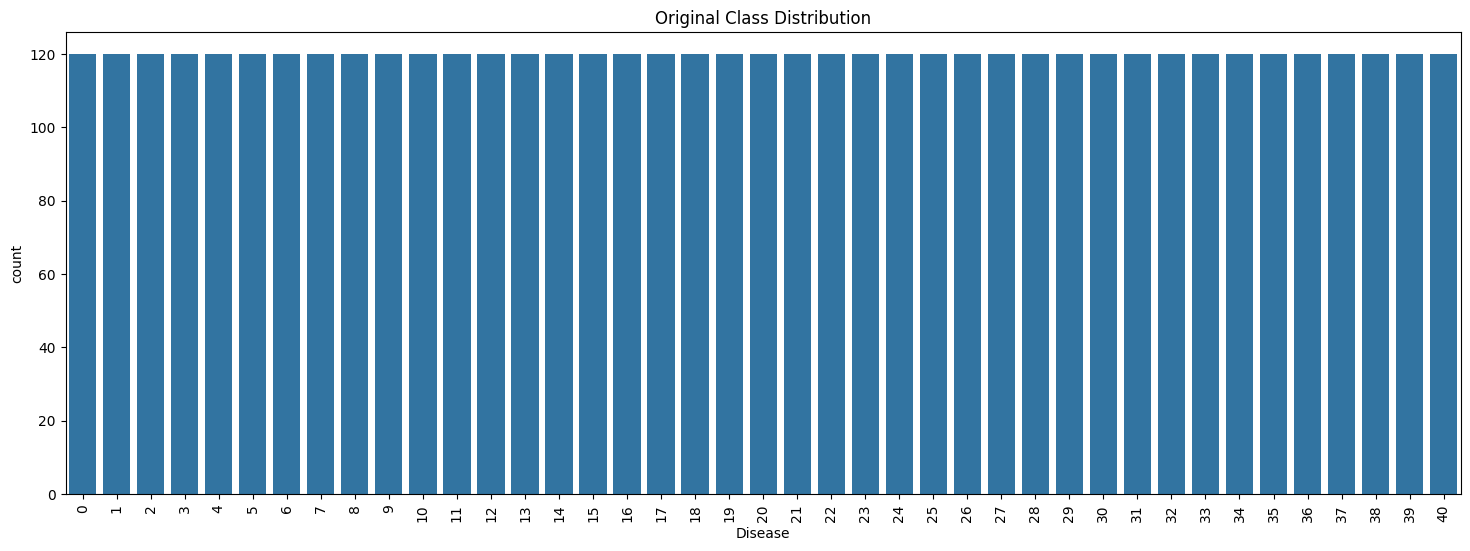

In [23]:
# ========================
# 📊 Visualize Class Distribution
# ========================
plt.figure(figsize=(18, 6))
sns.countplot(x=y)
plt.title("Original Class Distribution")
plt.xticks(rotation=90)
plt.show()


In [24]:

# ========================
# 🛠️ Train Models
# ========================
models = {
    "SVM": SVC(probability=True),
    "Naive Bayes": GaussianNB(),
    "Random Forest": RandomForestClassifier(random_state=42),
}

for name, model in models.items():
    model.fit(X_train, y_train)


In [25]:
# Save models
svm_model = models["SVM"]
nb_model = models["Naive Bayes"]
rf_model = models["Random Forest"]



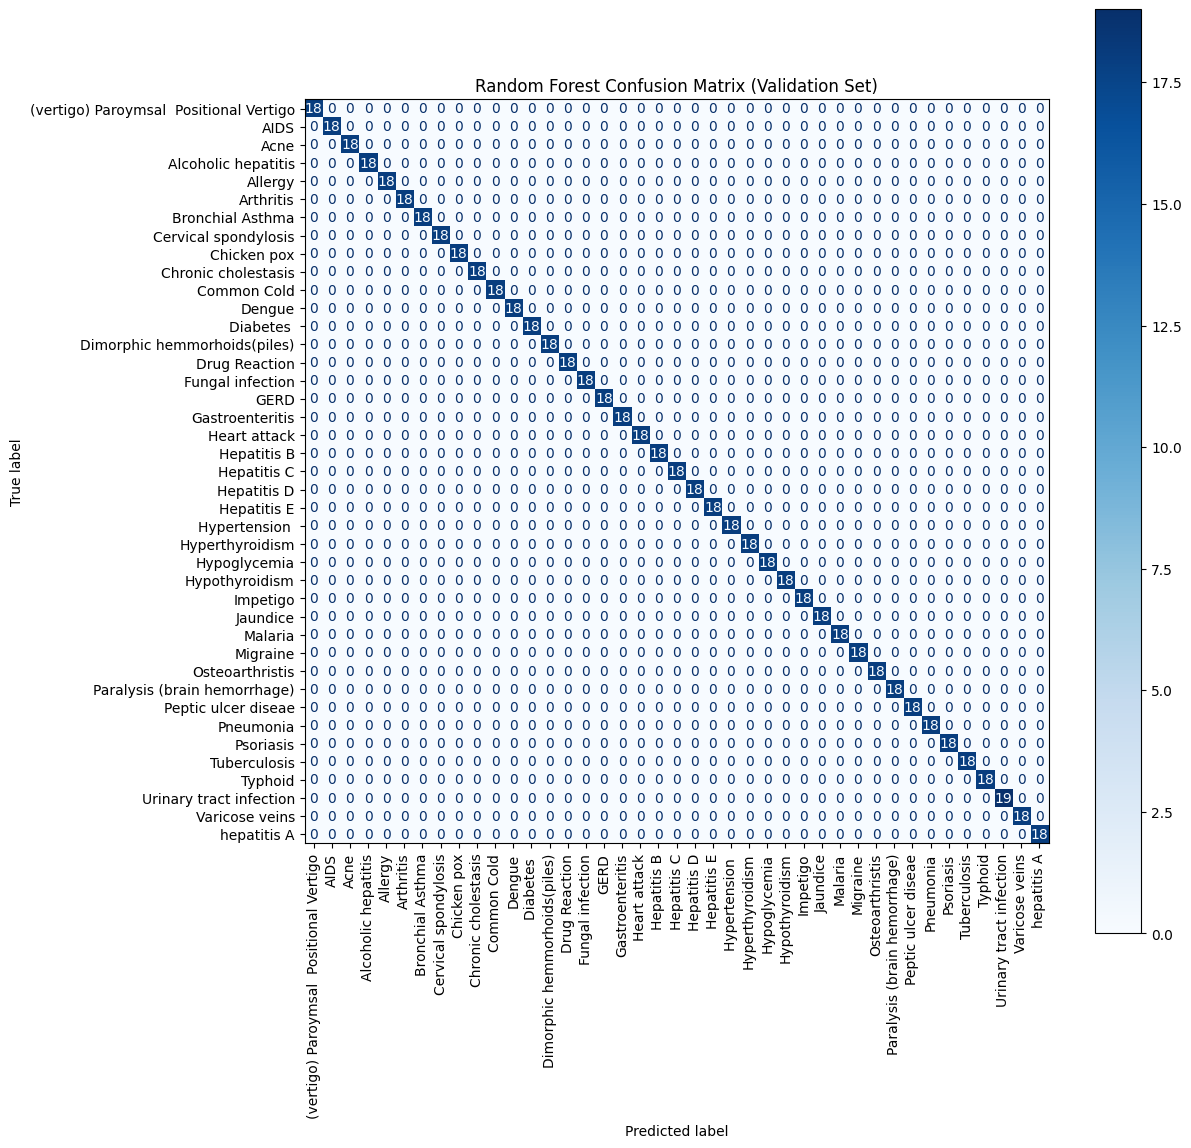

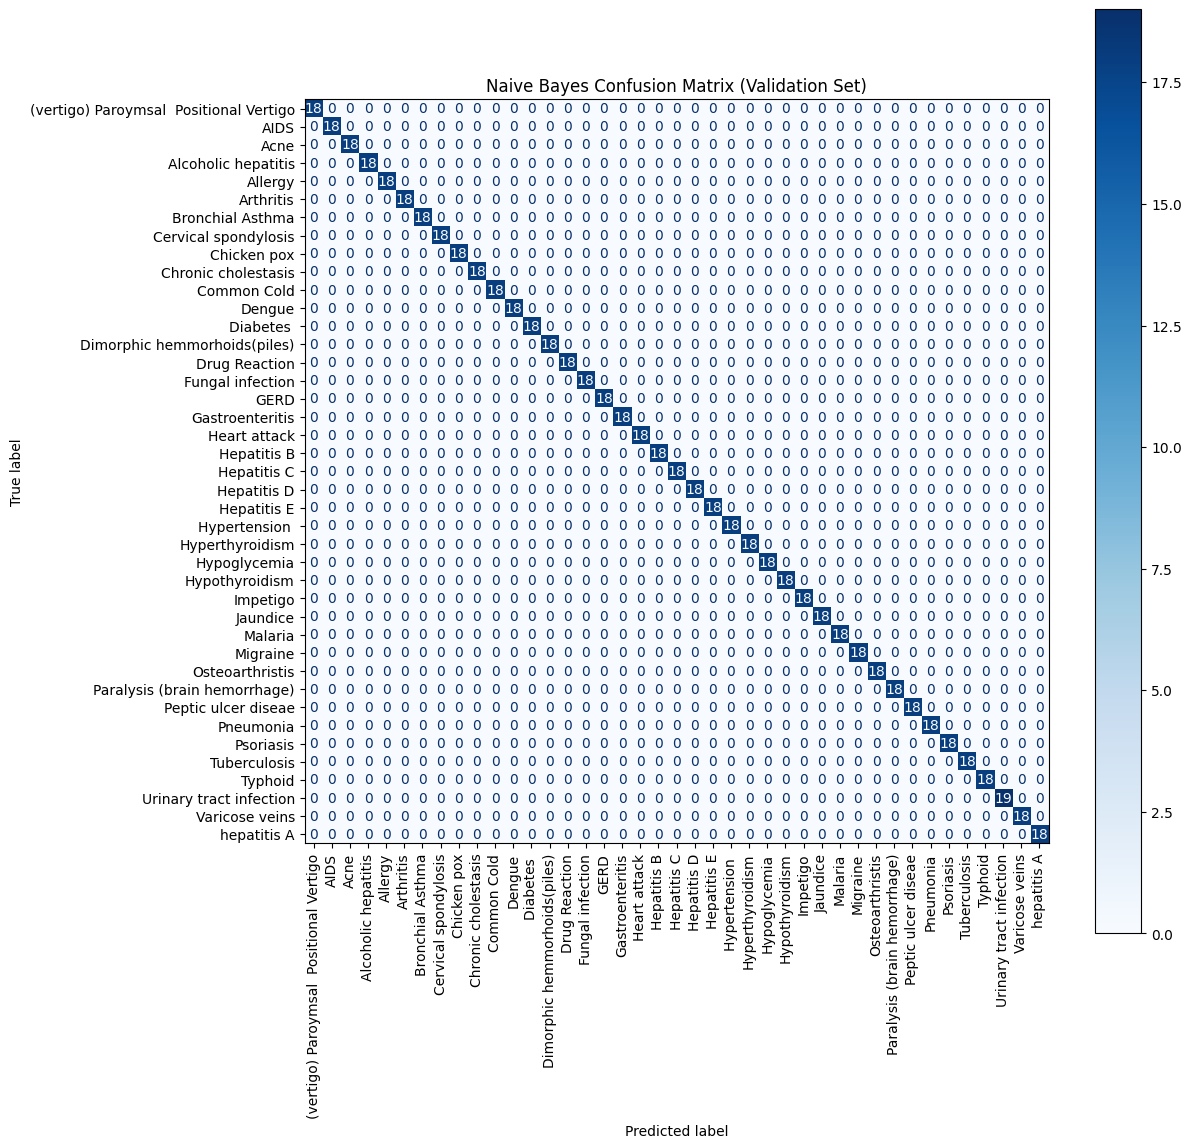

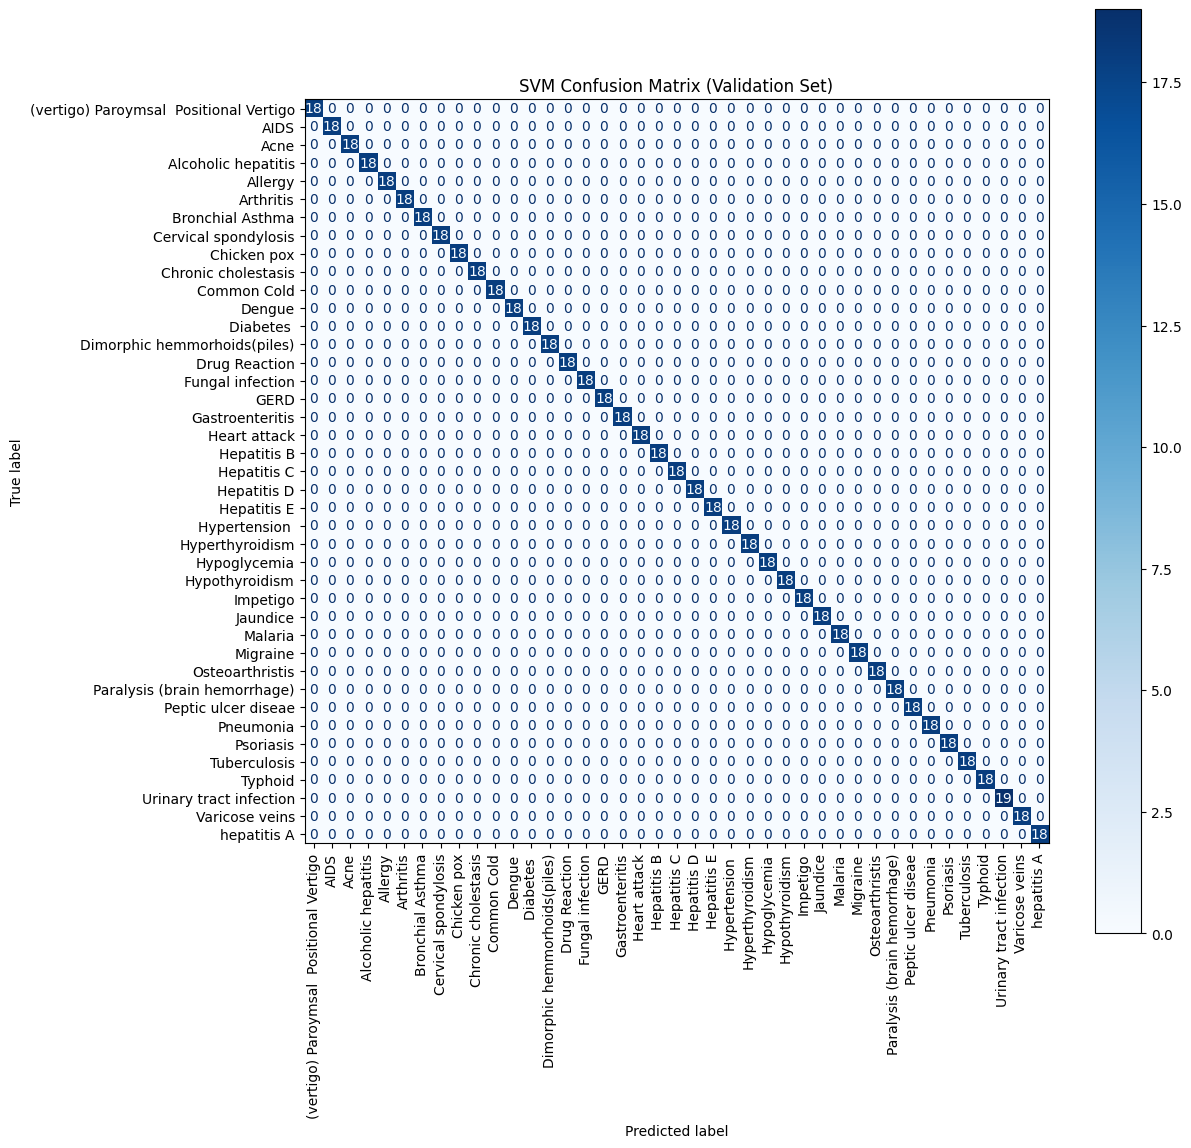

In [26]:
# ========================
# 📊 Confusion Matrix Plots
# ========================
def plot_confusion_matrix(model, X, y, title):
    preds = model.predict(X)
    cm = confusion_matrix(y, preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=encoder.classes_)
    fig, ax = plt.subplots(figsize=(12, 12))
    disp.plot(ax=ax, cmap='Blues', xticks_rotation=90)
    plt.title(title)
    plt.show()

# Plot for each model
plot_confusion_matrix(rf_model, X_val, y_val, "Random Forest Confusion Matrix (Validation Set)")
plot_confusion_matrix(nb_model, X_val, y_val, "Naive Bayes Confusion Matrix (Validation Set)")
plot_confusion_matrix(svm_model, X_val, y_val, "SVM Confusion Matrix (Validation Set)")




In [30]:
# ========================
# 🔥 Multi-Disease Prediction
# ========================
symptom_index = {symptom: idx for idx, symptom in enumerate(X.columns)}

def predict_multiple_diseases(input_symptoms):
    input_list = [0] * len(symptom_index)
    symptom_list = [s.strip().lower().replace(" ", "_") for s in input_symptoms.split(",")]

    for s in symptom_list:
        if s in symptom_index:
            input_list[symptom_index[s]] = symptom_severity.get(s.replace("_", " "), 0)

    input_df = pd.DataFrame([input_list], columns=X.columns)

    pred_rf = encoder.classes_[rf_model.predict(input_df)[0]]
    pred_nb = encoder.classes_[nb_model.predict(input_df)[0]]
    pred_svm = encoder.classes_[svm_model.predict(input_df)[0]]

    all_preds = [pred_rf, pred_nb, pred_svm]
    prediction_counts = Counter(all_preds)
    top_predictions = prediction_counts.most_common(3)

    result = []
    for disease, count in top_predictions:
        precautions = precaution_dict.get(disease, ["Not available"] * 4)
        result.append({
            "Disease": disease,
            "Votes": count,
            "Precautions": precautions
        })

    return result


In [31]:
# ========================
# 🔎 Example Prediction
# ========================
example_symptoms = "itching, skin rash, nodal skin eruptions"
results = predict_multiple_diseases(example_symptoms)

for idx, res in enumerate(results):
    print(f"Prediction #{idx+1}: {res['Disease']} (Votes: {res['Votes']}/3)")
    print("Precautions:")
    for p in res['Precautions']:
        print(f"- {p}")
    print("\n")

Prediction #1: Fungal infection (Votes: 3/3)
Precautions:
- bath twice
- use detol or neem in bathing water
- keep infected area dry
- use clean cloths




In [34]:
import pickle

pickle.dump(svm_model, open("svm_model.pkl", "wb"))
pickle.dump(nb_model, open("nb_model.pkl", "wb"))
pickle.dump(rf_model, open("rf_model.pkl", "wb"))
pickle.dump(encoder, open("encoder.pkl", "wb"))
